In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

# Displacement threshold for immobile molecules
immobile_stepsize_threshold_nm = 30
# alpha component threshold for constrained diffusion
threshold_alpha = 0.7

label_1 = "- DMSO, N="
label_2 = "+ DMSO, N="
label_3 = "+ Edavarone, N="
label_4 = "+ Riluzole, N="
color_1 = "#88a8cb"
color_2 = "#aabd8c"
color_3 = "#db8a74"
color_4 = "#552d9f"
palette = [color_1, color_2, color_3, color_4]

postfix = "FUS_drug.png"

folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/paper_figure_plots/post_bioRxiv_Figs/DiffusionProfiling-drug"
fname_AIO_1 = "../Data_for_all_plots/SPT_results_AIO_concat-FUS488_20ms_10kframes_noDMSO.csv"
fname_AIO_2 = "../Data_for_all_plots/SPT_results_AIO_concat-FUS488_20ms_10kframes_DMSO.csv"
fname_AIO_3 = "../Data_for_all_plots/SPT_results_AIO_concat-FUS488_20ms_10kframes_0h_edavarone.csv"
fname_AIO_4 = "../Data_for_all_plots/SPT_results_AIO_concat-FUS488_20ms_10kframes_0h_riluzole.csv"
fname_saspt_1 = "../Data_for_all_plots/saSPT-pooled-mobile-FUS488_20ms_10kframes_noDMSO.csv"
fname_saspt_2 = "../Data_for_all_plots/saSPT-pooled-mobile-FUS488_20ms_10kframes_DMSO.csv"
fname_saspt_3 = "../Data_for_all_plots/saSPT-pooled-mobile-FUS488_20ms_10kframes_0h_edavarone.csv"
fname_saspt_4 = "../Data_for_all_plots/saSPT-pooled-mobile-FUS488_20ms_10kframes_0h_riluzole.csv"

## Combine dataframes

In [2]:
def only_load_frac_csv(path, one_in_x):
    # Step 1: Determine total number of rows
    total_rows = sum(1 for row in open(path))

    # Step 2: Calculate indices of rows to read (e.g., every x-th row)
    rows_to_read = range(0, total_rows, one_in_x)

    # Step 3: Read the CSV using skiprows
    df = pd.read_csv(path, skiprows=lambda x: x not in rows_to_read)

    return df


In [3]:
os.chdir(folder_save)
df1 = only_load_frac_csv(fname_AIO_1, 1)
df2 = only_load_frac_csv(fname_AIO_2, 1)
df3 = only_load_frac_csv(fname_AIO_3, 2)
df4 = only_load_frac_csv(fname_AIO_4, 3)
print(label_1, df1.shape[0])
print(label_2, df2.shape[0])
print(label_3, df3.shape[0])
print(label_4, df4.shape[0])

- DMSO, N= 229230
+ DMSO, N= 381565
+ Edavarone, N= 334312
+ Riluzole, N= 413024


In [4]:
label_1 = label_1 + f"{df1.shape[0]:,}"
label_2 = label_2 + f"{df2.shape[0]:,}"
label_3 = label_3 + f"{df3.shape[0]:,}"
label_4 = label_4 + f"{df4.shape[0]:,}"
print(label_1)
print(label_2)
print(label_3)
print(label_4)

- DMSO, N=229,230
+ DMSO, N=381,565
+ Edavarone, N=334,312
+ Riluzole, N=413,024


In [5]:
df1.insert(0, "label", np.repeat(label_1, df1.shape[0]))
df2.insert(0, "label", np.repeat(label_2, df2.shape[0]))
df3.insert(0, "label", np.repeat(label_3, df3.shape[0]))
df4.insert(0, "label", np.repeat(label_4, df4.shape[0]))

# Below sequence is important for the layer order
df_AIO = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [6]:
df1 = pd.read_csv(fname_saspt_1, dtype=float)
df2 = pd.read_csv(fname_saspt_2, dtype=float)
df3 = pd.read_csv(fname_saspt_3, dtype=float)
df4 = pd.read_csv(fname_saspt_4, dtype=float)


def extract_log10D_density(df_current_file):
    range_D = df_current_file["diff_coef"].unique()
    log10D_density = []
    for log10D in range_D:
        df_current_log10D = df_current_file[df_current_file["diff_coef"] == log10D]
        log10D_density.append(df_current_log10D["mean_posterior_occupation"].sum())

    df_toplot = pd.DataFrame(
        {"log10D": np.log10(range_D), "Probability": log10D_density}, dtype=float
    )

    return df_toplot


df_saspt_1 = extract_log10D_density(df1)
df_saspt_2 = extract_log10D_density(df2)
df_saspt_3 = extract_log10D_density(df3)
df_saspt_4 = extract_log10D_density(df4)

df_saspt_1.insert(0, "label", np.repeat(label_1, df_saspt_1.shape[0]))
df_saspt_2.insert(0, "label", np.repeat(label_2, df_saspt_2.shape[0]))
df_saspt_3.insert(0, "label", np.repeat(label_3, df_saspt_3.shape[0]))
df_saspt_4.insert(0, "label", np.repeat(label_4, df_saspt_4.shape[0]))

# Below sequence is important for the layer order
df_saspt = pd.concat([df_saspt_1, df_saspt_2, df_saspt_3, df_saspt_4], ignore_index=True)

# Plots

### Localization error

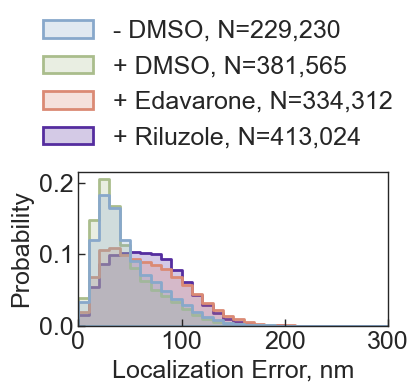

In [7]:
data = df_AIO[df_AIO["mean_stepsize_nm"] > immobile_stepsize_threshold_nm]
data = data[data["linear_fit_R2"] > 0.7]
# quantile = np.quantile(df_AIO["linear_fit_sigma"].dropna().to_numpy(), 0.999)
plt.figure(figsize=(4, 2))
ax = sns.histplot(
    data=data,
    x="linear_fit_sigma",
    hue="label",
    palette=palette,
    bins=30,
    binrange=(0, 300),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
)
# plt.axvline(immobile_stepsize_threshold_nm - 0.97, ls="--", color="#333232")
# plt.axvline(immobile_stepsize_threshold_nm + 0.97, ls="--", color="#f7b801")
plt.xlim(0, 300)

sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=1,
    title=None,
    frameon=False,
    fontsize=18,
)
plt.xlabel("Localization Error, nm", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("1.LocError_histo_" + postfix, format="png", bbox_inches="tight", dpi=300)

### Mean Step Size (whether static molecule)

- DMSO, N=229,230 158.64076908621902 0.2924039308880587
+ DMSO, N=381,565 148.81383335058524 0.22054276092321798
+ Edavarone, N=334,312 228.11366052423583 0.31328795462412307
+ Riluzole, N=413,024 225.18713613143743 0.25579930387411465


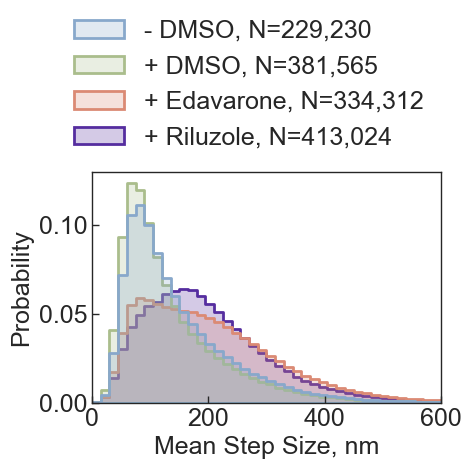

In [8]:
plt.figure(figsize=(4.5, 3))
ax = sns.histplot(
    data=df_AIO,
    x="mean_stepsize_nm",
    hue="label",
    palette=palette,
    bins=40,
    stat="probability",
    common_norm=False,
    binrange=(0, 600),
    lw=2,
    element="step",
)
plt.xlim(0, 600)
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=1,
    title=None,
    frameon=False,
    fontsize=18,
)
# plt.axvline(immobile_stepsize_threshold_nm - 1.6, ls="--", color="#333232")
# plt.axvline(immobile_stepsize_threshold_nm + 1.6, ls="--", color="#f7b801")
plt.xlabel("Mean Step Size, nm", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "2.mean_stepsize_nm_histo_" + postfix, format="png", bbox_inches="tight", dpi=300
)
print(
    label_1,
    data[data["label"] == label_1]["mean_stepsize_nm"].mean(),
    sem(data[data["label"] == label_1]["mean_stepsize_nm"].dropna()),
)
print(
    label_2,
    data[data["label"] == label_2]["mean_stepsize_nm"].mean(),
    sem(data[data["label"] == label_2]["mean_stepsize_nm"].dropna()),
)
print(
    label_3,
    data[data["label"] == label_3]["mean_stepsize_nm"].mean(),
    sem(data[data["label"] == label_3]["mean_stepsize_nm"].dropna()),
)
print(
    label_4,
    data[data["label"] == label_4]["mean_stepsize_nm"].mean(),
    sem(data[data["label"] == label_4]["mean_stepsize_nm"].dropna()),
)

### alpha distribution

- DMSO, N=229,230 116686
+ DMSO, N=381,565 189680
+ Edavarone, N=334,312 163290
- DMSO, N=229,230 0.7707385070888113 0.0010503801495681383
+ DMSO, N=381,565 0.7723070688962717 0.0008288599393258634
+ Edavarone, N=334,312 0.7998406232032963 0.0009278111585067973
+ Riluzole, N=413,024 0.7891757450808604 0.0008169259459763233


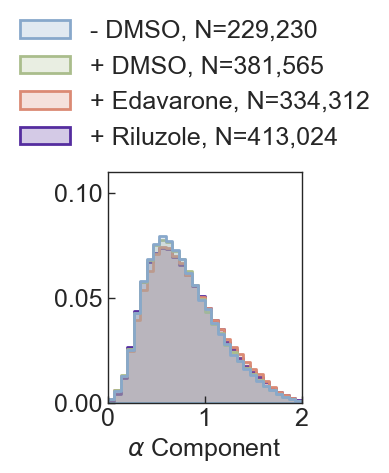

In [9]:
plt.figure(figsize=(2.5, 3))
data = df_AIO[df_AIO["mean_stepsize_nm"] > immobile_stepsize_threshold_nm]
data = data[data["loglog_fit_R2"] > 0.7]
data = data[data["alpha"] > 0]
ax = sns.histplot(
    data=data,
    x="alpha",
    hue="label",
    palette=palette,
    bins=30,
    stat="probability",
    common_norm=False,
    binrange=(0, 2),
    lw=2,
    element="step",
    # legend=False,
)
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=1,
    title=None,
    frameon=False,
    fontsize=18,
)
# plt.axvline(threshold_alpha - 0.011, ls="--", color="#f7b801")
# plt.axvline(threshold_alpha + 0.011, ls="--", color="#87a878")
plt.xlim(0, 2)
plt.ylim(0, 0.11)
plt.xlabel(r"$\alpha$ Component", fontsize=18)
plt.ylabel("")
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("3.alpha_histo_" + postfix, format="png", bbox_inches="tight", dpi=300)

print(label_1, data[data["label"] == label_1].shape[0])
print(label_2, data[data["label"] == label_2].shape[0])
print(label_3, data[data["label"] == label_3].shape[0])
print(
    label_1,
    data[data["label"] == label_1]["alpha"].mean(),
    sem(data[data["label"] == label_1]["alpha"].dropna()),
)
print(
    label_2,
    data[data["label"] == label_2]["alpha"].mean(),
    sem(data[data["label"] == label_2]["alpha"].dropna()),
)
print(
    label_3,
    data[data["label"] == label_3]["alpha"].mean(),
    sem(data[data["label"] == label_3]["alpha"].dropna()),
)
print(
    label_4,
    data[data["label"] == label_4]["alpha"].mean(),
    sem(data[data["label"] == label_4]["alpha"].dropna()),
)

### Angle Distribution

In [10]:
lst_angle = []
lst_label = []
for _, row in df_AIO[df_AIO["mean_stepsize_nm"] > immobile_stepsize_threshold_nm].iterrows():
    angles = np.fromstring(
        row["list_of_angles"][1:-1],
        dtype=float,
        sep=", ",
    )
    labels = np.repeat(row["label"], angles.shape[0])
    lst_angle.extend(angles)
    lst_label.extend(labels)

data = pd.DataFrame(
    {
        "angle": np.abs(lst_angle),
        "label": lst_label,
    },
    dtype=object,
)

KeyboardInterrupt: 

- DMSO
N=229,230 118.71613846994364 0.039776061687510696
+ DMSO
N=381,565 119.13646940815259 0.03163189296748094
+ Edavarone
N=334,312 119.28803179375366 0.03456134734301278


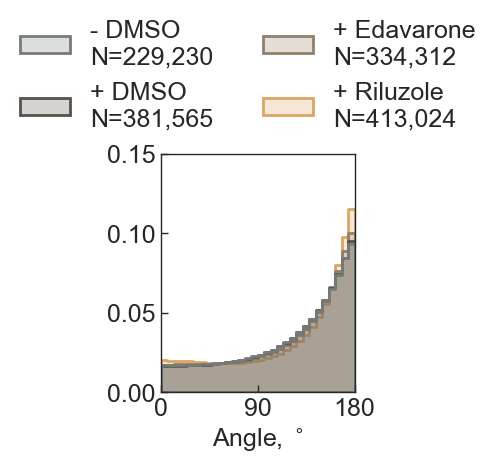

In [ ]:
plt.figure(figsize=(2.5, 3.1))
bins = 30
ax = sns.histplot(
    data=data,
    x="angle",
    hue="label",
    palette=palette,
    bins=bins,
    stat="probability",
    common_norm=False,
    binrange=(0, 180),
    lw=2,
    element="step",
    # legend=False,
)
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=1,
    title=None,
    frameon=False,
    fontsize=18,
)
# plt.axhline(1 / bins - 0.0004, color="#87a878", ls="--")
# plt.axhline(1 / bins + 0.0004, color="#f7b801", ls="--")
plt.xlim(0, 180)
plt.xticks([0, 90, 180])
plt.ylim(0, 0.15)
# plt.yticks([0, 0.03, 0.06])
plt.xlabel("Angle, $^\circ$", fontsize=18)
plt.ylabel("")
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("4.angle_histo_" + postfix, format="png", bbox_inches="tight", dpi=300)
print(
    label_1,
    data[data["label"] == label_1]["angle"].mean(),
    sem(data[data["label"] == label_1]["angle"].dropna()),
)
print(
    label_2,
    data[data["label"] == label_2]["angle"].mean(),
    sem(data[data["label"] == label_2]["angle"].dropna()),
)
print(
    label_3,
    data[data["label"] == label_3]["angle"].mean(),
    sem(data[data["label"] == label_3]["angle"].dropna()),
)

### D distribution among the non contrained molecules

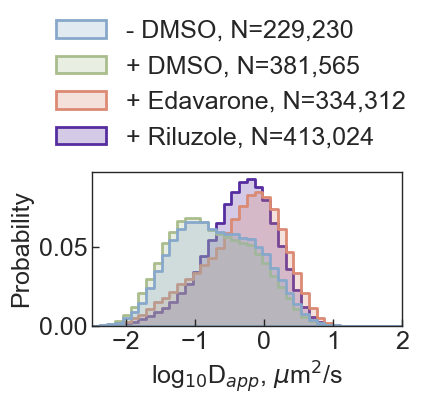

In [11]:
data = df_AIO[df_AIO["linear_fit_R2"] > 0.7]
data = data[data["mean_stepsize_nm"] > immobile_stepsize_threshold_nm]
data = data[data["alpha"] > 0.5]
plt.figure(figsize=(4, 2))
ax = sns.histplot(
    data=data,
    x="linear_fit_log10D",
    hue="label",
    palette=palette,
    bins=40,
    stat="probability",
    common_norm=False,
    binrange=(-2.5, 2),
    lw=2,
    element="step",
)
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=1,
    title=None,
    frameon=False,
    fontsize=18,
)

plt.xlim(-2.5, 2)
plt.xticks([-2, -1, 0, 1, 2])
plt.xlabel(r"log$_{10}$D$_{app}$, $\mu$m$^2$/s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "5.ApparentD_linear_histo_" + postfix, format="png", bbox_inches="tight", dpi=300
)

### Plot saSPT

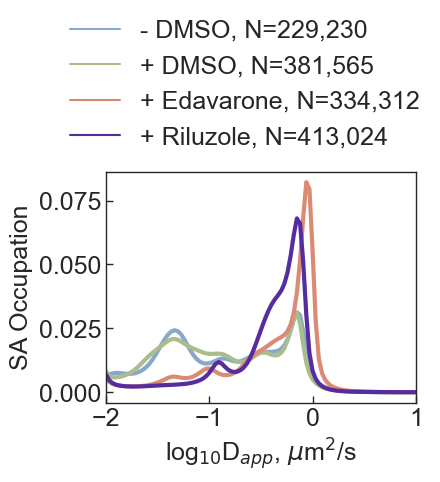

In [ ]:
plt.figure(figsize=(4, 3))
ax = sns.lineplot(
    data=df_saspt,
    x="log10D",
    y="Probability",
    hue="label",
    palette=palette,
    lw=3,
    # legend=False,
)
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=1,
    title=None,
    frameon=False,
    fontsize=18,
)
log10D = df_saspt["log10D"].to_numpy(dtype=float)
plt.xlim(-2, 1)
plt.xticks([-2, -1, 0, 1])
# plt.ylim(0, 0.11)
plt.xlabel(r"log$_{10}$D$_{app}$, $\mu$m$^2$/s", fontsize=18)
plt.ylabel("SA Occupation", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("6.saspt_histo_" + postfix, format="png", bbox_inches="tight", dpi=600)

In [ ]:
from scipy.signal import find_peaks


def find_major_peak(x, y):
  """
  Finds the x value corresponding to the major peak (highest value) in the y data.

  Args:
      x: A 1D NumPy array representing the x-axis values.
      y: A 1D NumPy array representing the y-axis values (curve).

  Returns:
      A tuple containing the x value and the corresponding y value of the major peak,
      or None if no peak is found.
  """
  peaks, _ = find_peaks(y)
  # If no peaks are found, return None
  if len(peaks) == 0:
    return None

  # Find the index of the major peak (highest value in y)
  major_peak_index = peaks[np.argmax(y[peaks])]
  major_peak_x = x[major_peak_index]
  major_peak_y = y[major_peak_index]

  return major_peak_x, major_peak_y


major_peak_x, major_peak_y = find_major_peak(
    df_saspt[df_saspt["label"] == label_1]["log10D"].to_numpy(float),
    df_saspt[df_saspt["label"] == label_1]["Probability"].to_numpy(float),
)
print(label_1, 10**major_peak_x)
major_peak_x, major_peak_y = find_major_peak(
    df_saspt[df_saspt["label"] == label_2]["log10D"].to_numpy(float),
    df_saspt[df_saspt["label"] == label_2]["Probability"].to_numpy(float),
)
print(label_2, 10**major_peak_x)
major_peak_x, major_peak_y = find_major_peak(
    df_saspt[df_saspt["label"] == label_3]["log10D"].to_numpy(float),
    df_saspt[df_saspt["label"] == label_3]["Probability"].to_numpy(float),
)
print(label_3, 10**major_peak_x)

- DMSO
N=229,230 0.7054802310718645
+ DMSO
N=381,565 0.7054802310718645
+ Edavarone
N=334,312 0.8697490026177834
